<a href="https://www.kaggle.com/code/michajurzak/wycena-samochod-w-05-2023-danymi-z-01-2022?scriptVersionId=166065089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Wstęp**
[Zbór cen samochodów z 01.2022.](https://www.kaggle.com/datasets/aleksandrglotov/car-prices-poland)  

Powyższy zbór został skomponowany ze znanej publicznej strony internetowej przy 
użyciu Selenium i języka programowania python.  


Zbiór zawiera informacje o marce, modelu, generacji, roku produkcji, przebiegu, typie oraz objętości silnika wraz z lokalizacją. 

*Wykonali: Albert Dańko, Jakub Ficek, Michał Jurzak*

# **Temat analizy**
Analiza jest projektem końcowym na zaliczenie z przedmiotu Statystyczna Analiza Danych.  
Celem i motywacją stojącą za niniejszą analizą jest porównanie cen samochodów z okresu stycznia 2022 oraz maja 2023, a zasadniczym celem jest predykowanie cen samochodów z ówczesnego okresu, a następnie przy użyciu scrapera i pobraniu obecnych cen, sprawdzenie poprawności utworzonego modelu i różnicy cen.  

* H<sub>0</sub> : Za pomocą historycznych danych można przewidzieć bieżące ceny samochodów.
* H<sub>a</sub> : Za pomocą historycznych danych nie można przewidzieć bieżących cen samochodów.



In [1]:
!pip install unidecode

In [2]:
import pandas as pd
import numpy as np
import io
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, randint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-prices-poland/Car_Prices_Poland_Kaggle.csv
/kaggle/input/scraped-car-prices-from-otomoto/car.csv


In [4]:
df = pd.read_csv("../input/car-prices-poland/Car_Prices_Poland_Kaggle.csv")

df.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


## Ilość danych

In [5]:
df.shape

(117927, 11)

Powyższy zbiór zawiera około 118 tysięcy różnych obserwacji z popularnej strony do sprzedaży pojazdów osobowych w Polsce.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


Ze względu na to, że rok produkcji samochodu nie może być użyty w modelu regresji liniowej, zostanie on zamieniony na wiek samochodu. Wykonane jest to poprzez odjęcie od daty zebrania danych roku produkcji.

In [7]:
df['age'] = 2022 - df['year']

## Opis zmiennych
### Zmienne jakościowe:
- mark - marka
- model 
- vol_engine - objętość silnika
- fuel - rodzaj paliwa
### Zmienne ilościowe:
- mileage - przebieg
- price - cena
- age - wiek pojazdu

## Statystyki opisowe

In [8]:
df.describe().round(2)

,Unnamed: 0,year,mileage,vol_engine,price,age
count,117927.00,117927.00,117927.00,117927.00,117927.00,117927.00
mean,58963.00,2012.93,140976.79,1812.06,70299.88,9.07
std,34042.74,5.69,92369.36,643.61,84824.58,5.69
min,0.00,1945.00,0.00,0.00,500.00,0.00
25%,29481.50,2009.00,67000.00,1461.00,21000.00,4.00
50%,58963.00,2013.00,146269.00,1796.00,41900.00,9.00
75%,88444.50,2018.00,203000.00,1995.00,83600.00,13.00
max,117926.00,2022.00,2800000.00,7600.00,2399900.00,77.00


Powyższe statystyki mogą zawierać nieprawidłowości, dlatego teraz należy usunąć nieralne dane.

## Usuwanie danych

Na samym początku usunięte zostaną dane, które według nas są zbędne w wyliczaniu cen samochodów.

In [9]:
df.drop(columns=['year' ,'city', 'province'], inplace=True)

Należy sprawdzić puste wartości w danych kolumnach.

In [10]:
df.isna().sum()

Unnamed: 0             0
mark                   0
model                  0
generation_name    30085
mileage                0
vol_engine             0
fuel                   0
price                  0
age                    0
dtype: int64

Kolumna generation_name posiada dużo przypadków które nie posiadają żadnych wartości. Warto również porzucić kolumnę Unnamed: 0, która jedynie numeruje rzędy.

In [11]:
df.drop(columns=["generation_name","Unnamed: 0"],inplace=True)

Zauważyliśmy, że samochody z silnikiem elektrycznym nie mają podanej objętości silnika, lub mają ją podaną w innej jednostce niż reszta samochodów (kWh).

In [12]:
df.query('fuel=="Electric"').describe().round(2)

,mileage,vol_engine,price,age
count,885.00,885.00,885.00,885.00
mean,11077.97,10.36,193078.92,1.91
std,24041.52,105.29,110102.44,1.92
min,0.00,0.00,22500.00,0.00
25%,5.00,0.00,120900.00,1.00
50%,10.00,0.00,159900.00,1.00
75%,9000.00,0.00,257470.00,2.00
max,150000.00,1580.00,803900.00,9.00


Jak widać po przeprowadzonych statystykach opisowych samochodów elektrycznych, przynajmniej 75% posiada pojemność równą 0, co mogłoby zaburzyć proces przewidywania cen takich samochodów, tak więc decydujemy się na porzucenie tego typu samochodów.

In [13]:
df.drop(df.query('fuel == "Electric"').index, inplace=True)

Należy sprawdzić czy pojemność pozostałych samochodów jest niezerowa i je usunąć, ponieważ dane mogły zostać źle wprowadzone.

In [14]:
df.query('vol_engine==0')

,mark,model,mileage,vol_engine,fuel,price,age
3202,opel,astra,0,0,Diesel,91600,1
3248,opel,astra,0,0,Diesel,100000,1
5496,opel,corsa,0,0,Gasoline,75890,1
5498,opel,corsa,0,0,Gasoline,76790,1
5699,opel,crossland-x,0,0,Gasoline,80968,1
...,...,...,...,...,...,...,...
111456,seat,ateca,0,0,Gasoline,129055,0
111457,seat,ateca,0,0,Gasoline,129055,0
111458,seat,ateca,0,0,Gasoline,143314,0
113303,seat,leon,0,0,Gasoline,102085,1


In [15]:
df.drop(df.query('vol_engine==0').index, inplace=True)

## Statystyki opisowe po czyszczeniu danych

In [16]:
df.describe().round(2)

,mileage,vol_engine,price,age
count,116667.00,116667.00,116667.00,116667.00
mean,142390.73,1831.55,68849.14,9.15
std,91805.16,618.93,83237.60,5.66
min,1.00,499.00,500.00,0.00
25%,70000.00,1482.00,20900.00,5.00
50%,148000.00,1796.00,41000.00,9.00
75%,203953.50,1995.00,81500.00,13.00
max,2800000.00,7600.00,2399900.00,77.00


Po czyszczeniu zostało nam z 117927 samochodów 116667. Odchylenie standardowe jest bardzo wysokie dla przebiegu, co oznacza, że ten parametr może być bardzo losowy, jednakowoż można intuicyjnie przypuszczać, że przebieg ma odwrotnie proporcjonalny wpływ na cenę.  
W przypadku ceny samochodów, mediana jest znacznie niższa od średniej, co oznacza, że jest więcej samochodów droższych niż 41000.

##Stworzenie histogramu i wykresu ramka-wąsy dla zmiennej badanej price

Tą cześć wykonamy przy użyciu biblioteki matplotlib.
Zaczniemy od stworzenia histogramu.

/tmp/ipykernel_20/2611771148.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


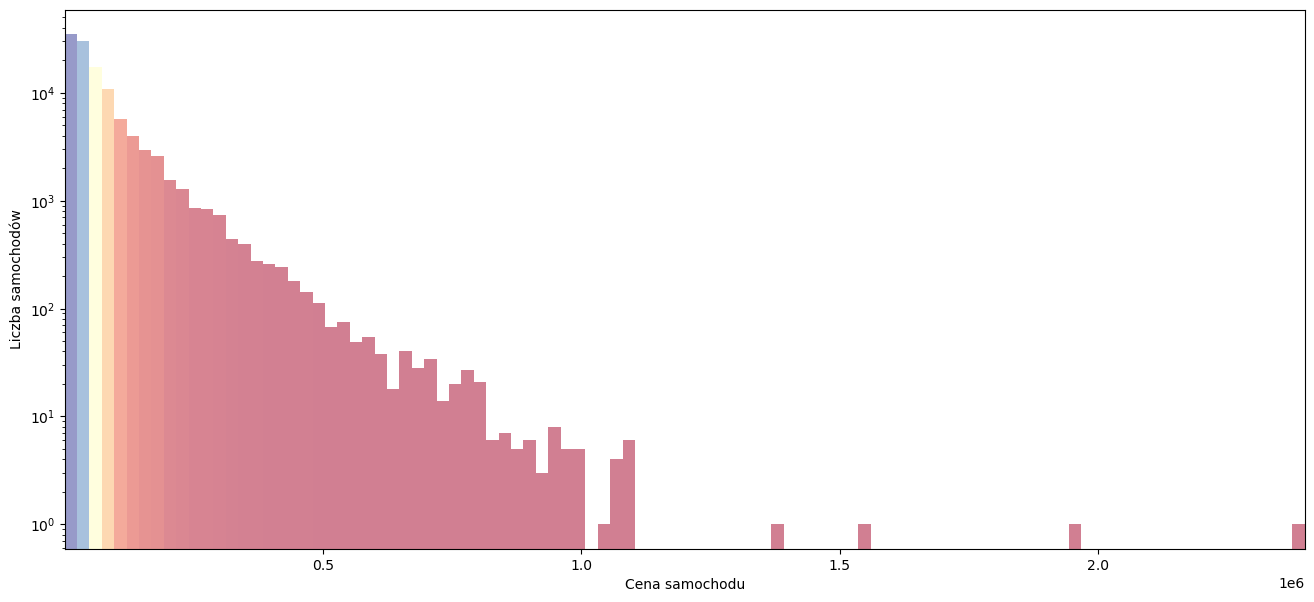

In [17]:
# rozmiar wykresu w calach
fig, ax = plt.subplots(figsize=(16,7))

n, bins, patches = ax.hist(df['price'], bins=100, alpha=0.5)
col = (n-n.min())/(n.max()-n.min())
cm = plt.cm.get_cmap('RdYlBu')
for c, p in zip(col, patches):
   plt.setp(p, 'facecolor', cm(c))


ax.set_xlabel('Cena samochodu')
ax.set_ylabel('Liczba samochodów')

ax.set_xlim([df['price'].min(), df['price'].max()])
ax.set_yscale('log')
plt.show()

Powyższy wykres przedstawia histogram w skali logarytmicznej zmiennej price. Został on w taki sposób przedstawiony, ponieważ pokazuje on w ten sposób ilość samochodów w danym przedziale cenowym. Jak widać, im niższe wartości cenowe, tym więcej samochodów (kolor intensywnie fioletowy). Pojawia się też niewiele samochodów o cenie większej niż milion. Jednakowy kolor (wyblakły róż) świadczy o relatywnie niewielkiej ilości samochodów (1000 lub mniej). 

Następnie zaczeliśmy tworzyć wykres ramka-wąsy. Stworzony jest za pomocą opcji boxplot, na takiej samej zasadzie jak powyższy histogram.

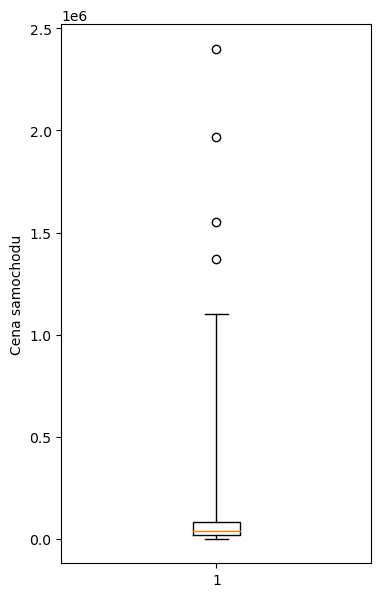

In [18]:
fig, ax = plt.subplots(figsize=(4,7))

ax.boxplot(df['price'], whis=20)
ax.set_ylabel('Cena samochodu')

plt.show()

Powyższy wykres ramka wąsy pokazuje nam jak bardzo rozproszone są wartości samochodów między trzecim a czwartym kwartylem. Co warto zauważyć, to jak bardzo skondensowane na tym wykresie są samochody do trzeciego kwartyla. Jak już wcześniej wnioskowaliśmy, ten wykres dobrze pokazuje, że średnia jest zawyżona przez skrajne wartości i statystyki opisowe ukazały, że znajduje się ona między trzecim a czwartym kwartylem.

##Stworzenie skategoryzowanego histogramu i wykresu ramka-wąsy dla zmiennej price.

Za pomocą boxplota z biblioteki seaborn stworzylismy wykres ramka wąsy zależny od marki oraz dodatkowo zależny od rodzaju silnika.

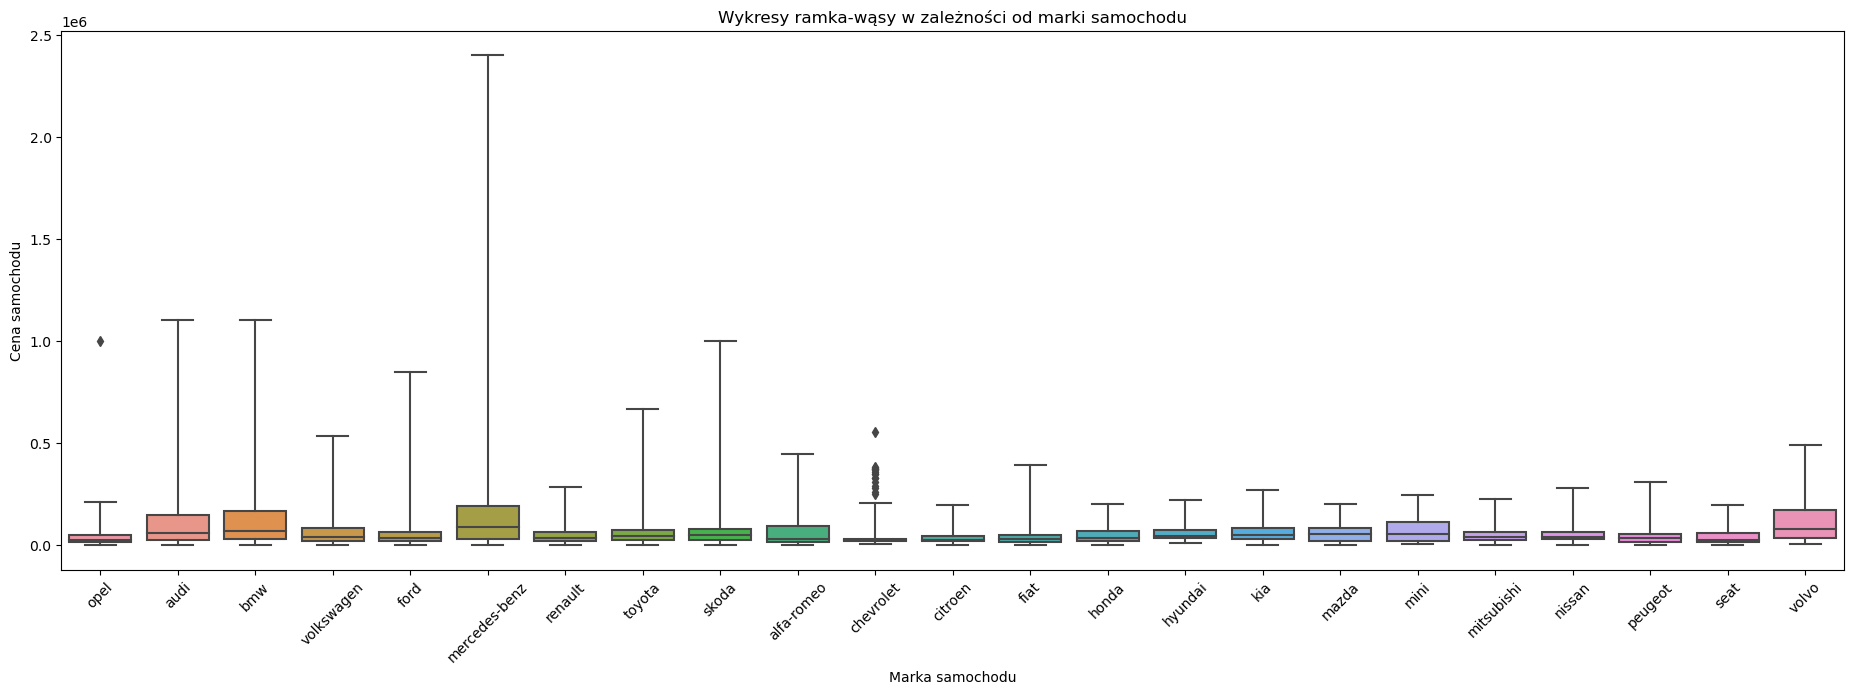

In [19]:
fig, ax = plt.subplots(figsize=(23,7))
ax = sns.boxplot(x = 'mark', y = 'price', data = df, whis=20)
plt.xticks(rotation=45)
# Dodaj legendę
#plt.legend(title='0 - mezczyzna, 1 - kobieta', loc='upper left')

ax.set(xlabel='Marka samochodu', ylabel='Cena samochodu', title='Wykresy ramka-wąsy w zależności od marki samochodu')

plt.show()

Na powyższym skategoryzowanym wykresie jako pierwsze wybijają się przede wszystkim mercedes-benz, bwm oraz audi. Te marki jako jedne z niewielu obecnych są droższe i od drugiego kwartyla wzwyż mają duży rozrzut cen. Marki z najmniejszym rozrzutem cenowym to np. Opel, Fiat lub Renault. Ciekawym przypadkiem jest Chevrolet, gdzie 3/4 samochodów jest bardzo mocno skondensowane, natomiast skrajne wartości maksymalne posiadają znaczny rozstrzał cenowy.

In [20]:
df_mark_names = df['mark'].unique()
df_model_names = df['model'].unique()
df.mark.value_counts()

opel             11860
audi             11825
bmw              10873
volkswagen       10735
ford              9592
mercedes-benz     7033
renault           6902
skoda             5814
toyota            5120
peugeot           5004
volvo             4374
hyundai           3997
kia               3695
nissan            2997
mazda             2846
seat              2836
fiat              2781
citroen           2719
honda             2176
mitsubishi        1113
mini              1064
alfa-romeo         703
chevrolet          608
Name: mark, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


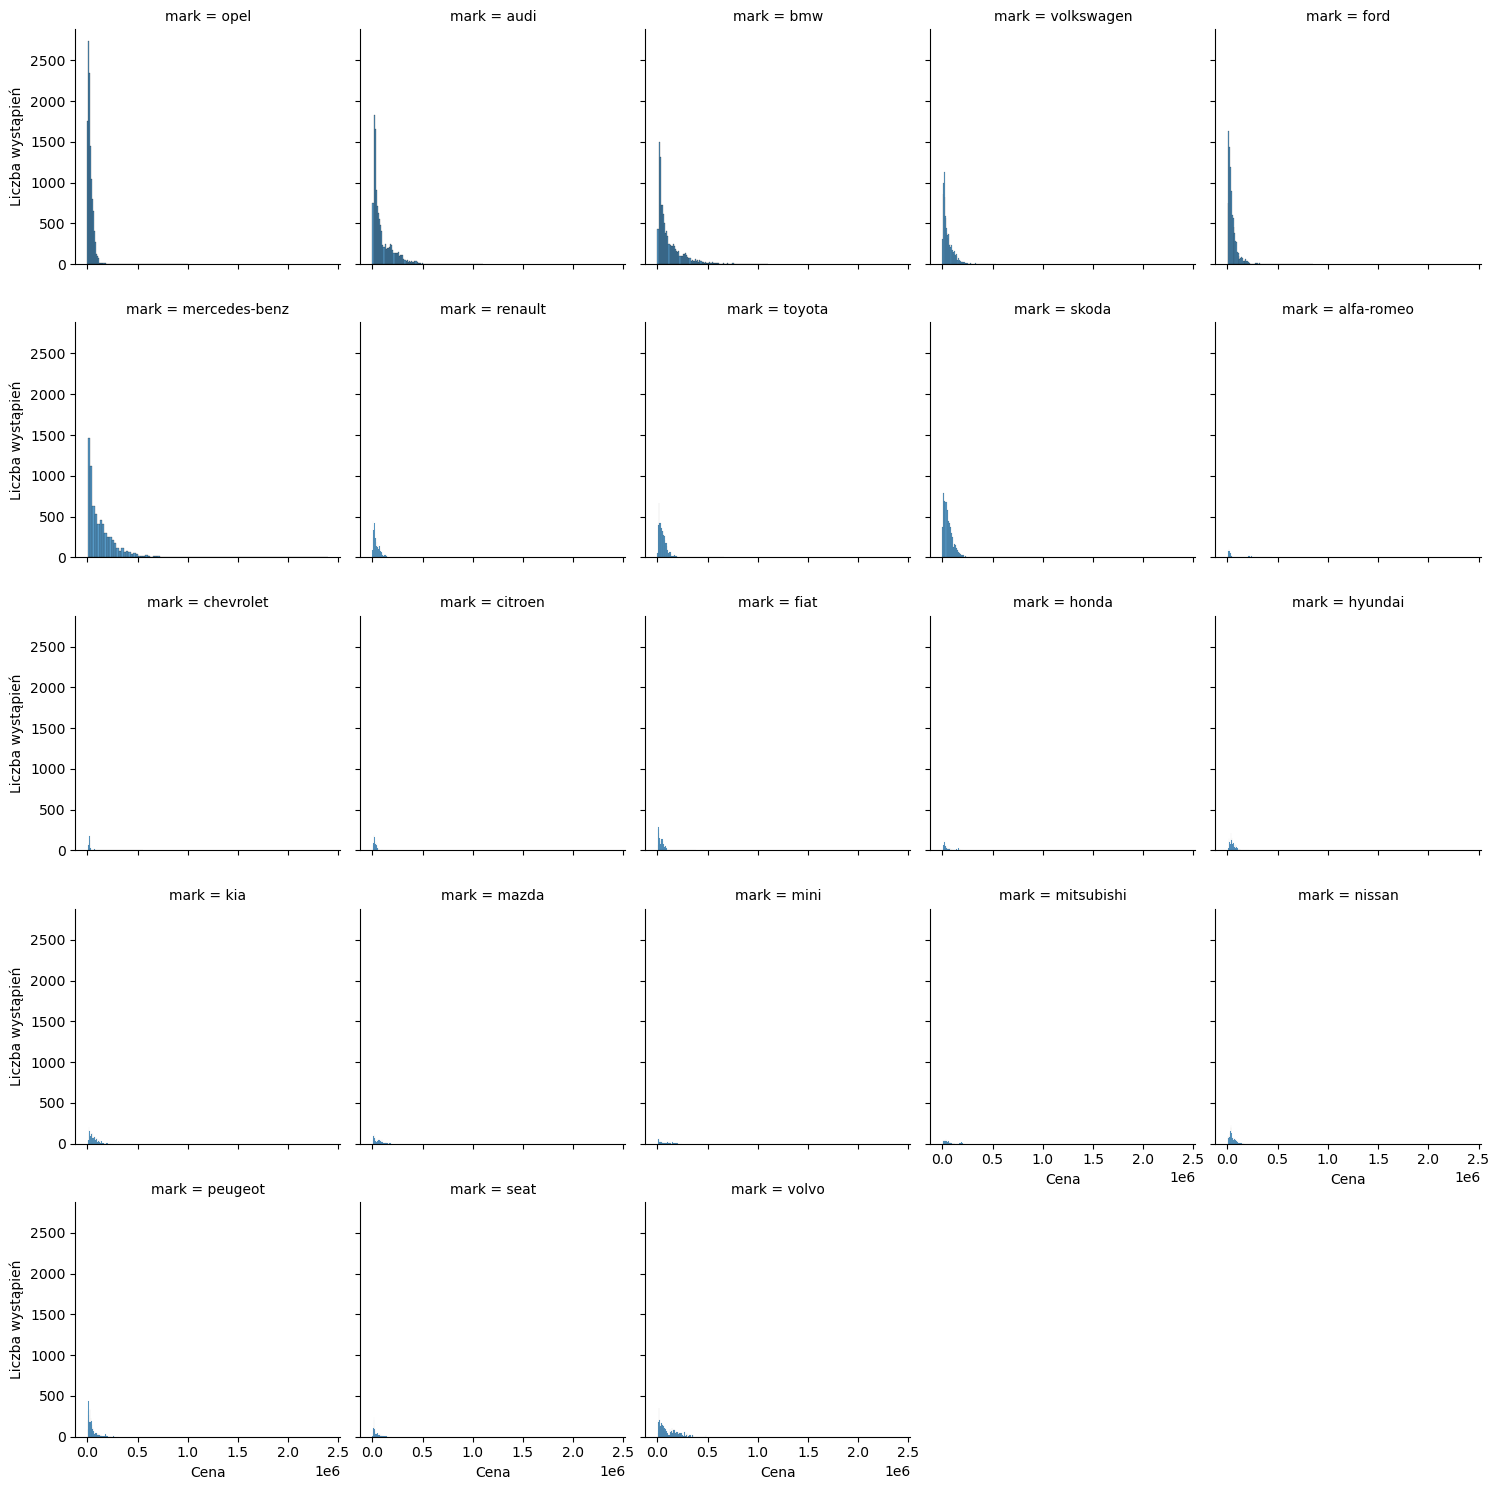

In [21]:
g = sns.FacetGrid(df, col="mark", col_wrap=5)
g.map(sns.histplot, "price", bins=100)

#Dodaj legendę
g.set_axis_labels("Cena", "Liczba wystąpień")


Powyższa mapa histogramów pokazuje nam jakie marki wystepują najczęściej przy danych cenach. Zauważyć dość szybko można których samochodów sprzedaję się najwięcej w jakich przedziałach cenowych. Na histogramach wyróżniają sie przede wszystkim opel, volvo, bmw, mercedes, audi, ford i volkswagen. Te marki mają najwięcej samochodów na rynku gotowych do sprzedaży. W niektórych ceny rozkładają się stopniowo (volvo, mercedes) w innych jest to bardziej widoczny spadek (bwm, audi, opel), spowodowany dużą ilościa samochodów o najmniejszych cenach, ale także ich wystepowaniem przy większych. Każdy rodzaj klienta jest w stanie znaleźć samochód tej marki dla siebie. 

Stworzyliśmy także wykres słupkowy, aby sprawdzić jak ilościowo rozkładają się wysztkie marki, czyli których jest najwięcej wystawionych na sprzedaż, nie patrząc na cene ich wystawienia.

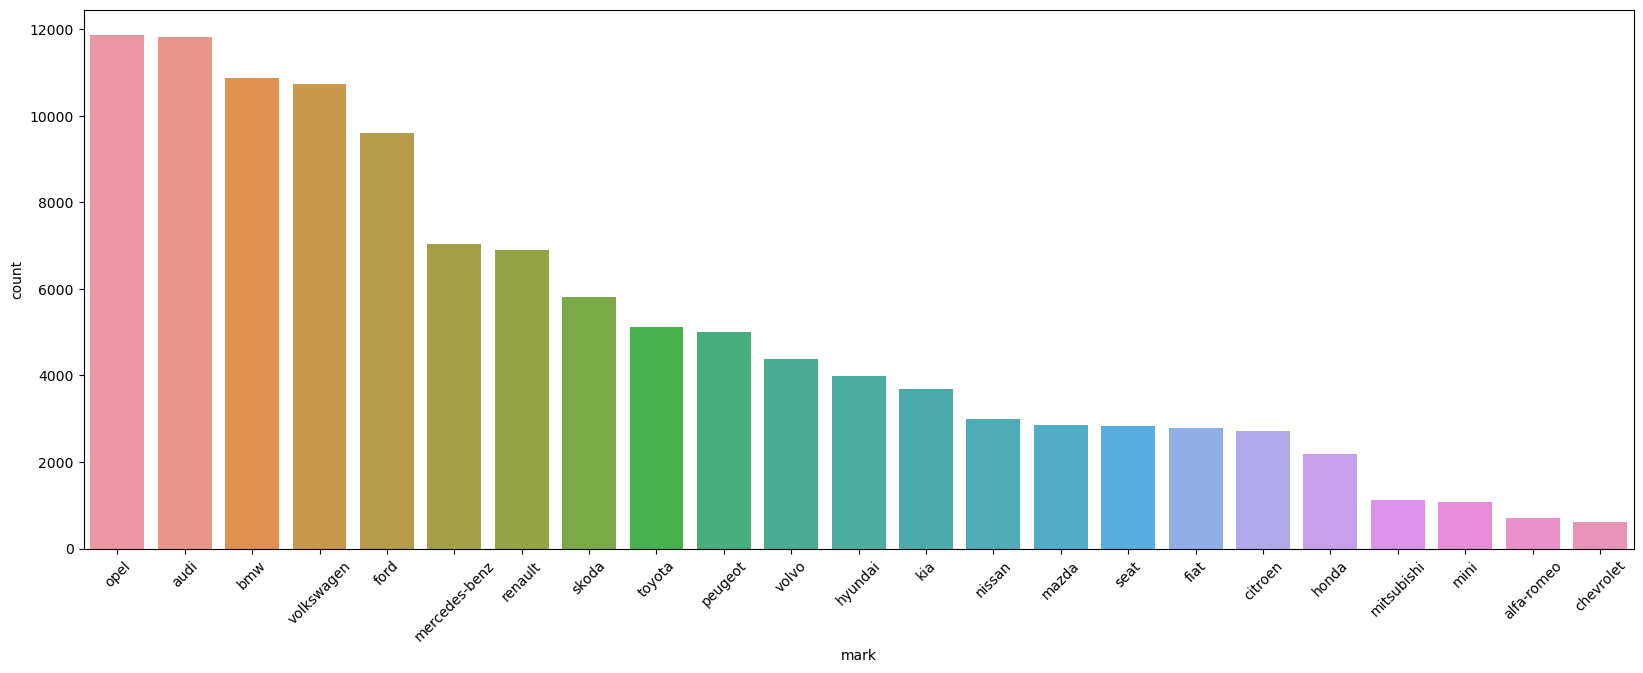

In [22]:
plt.figure(figsize=(20,7))
sns.countplot(x=df["mark"], order = df["mark"].value_counts().index)
plt.xticks(rotation=45)
plt.show()

Wykres ten pokazuje nam, że najwięcej samochodów jest marki opel, audi, bmw i stopniowo zmniejszają się ilości innych w miejszych nakładach.

## Weryfikacja hipotezy o zgodności empirycznego rozkładu wybranej cechy z rozkładem normalnym

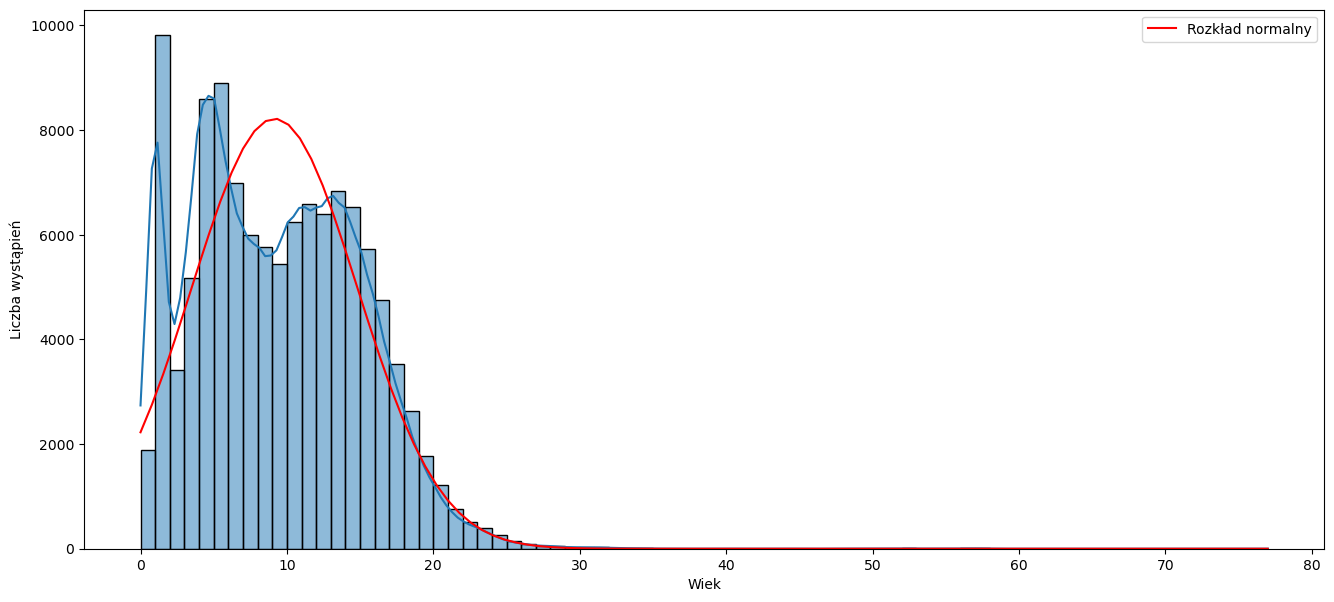

In [23]:
# Dane wieku z DataFrame `df`
data = df['age']

# Obliczanie średniej i odchylenia standardowego dla danych
mean = np.mean(data)
std = np.std(data)

# Tworzenie figury i osi
fig, ax = plt.subplots(figsize=(16, 7))

# Wykreślanie histogramu przy użyciu seaborn
sns.histplot(data=df, x="age", bins=77, kde=True, ax=ax)

# Wyliczenie szerokości przedziałów
bin_width = (np.max(data) - np.min(data)) / 77

# Wygenerowanie teoretycznego rozkładu normalnego
x = np.linspace(np.min(data), np.max(data), 100)
y = norm.pdf(x, mean, std)

# Skalowanie wartości rozkładu normalnego do odpowiadającej skali osi Y
scale_factor = len(data) * bin_width
ax.plot(x, y * scale_factor, 'r', label='Rozkład normalny')

# Dodanie legendy
ax.legend()

# Dodanie nazw osi
ax.set_xlabel('Wiek')
ax.set_ylabel('Liczba wystąpień')

plt.show()

Histogram pokazuje nam jak wygląda rozkład empiryczny dla zmiennej wieku samochodu, oraz rozkład normalny (przewidywany). Odrazu można zauważyć, że hipotezę, która zakładała zgodność tych rozkładów należy odrzucić. Samochodów w wieku 2 latach jest bardzo duża ilość, przez co zaburza to rozkład. Jest też widoczna za mało ilość pojazdów na pewnych przedziałach oraz inne znaczne wzrosty. Samochody z wiekiem powyżej 16 lat mają już rozkład bardzo zbliżony do normalnego. Jednak brakuje pojazdów w wieku od około 7 do 13 lat. Może to wynikać z bardzo dużego zaintereowania samochodami w tym wieku ze względu na dobrą cenę oraz stosunkową dobrą jakość.

# Korelacja

Na początku przed podejściem do stworzenia macierzy korelacji zamieniamy model oraz markę na liczby, aby dało się przedstawić naszemu modelowi regresji wartości liczbowe, ponieważ na nazwach nie był w stanie obliczyć zależności pomiędzy ceną, a marką czy modelem.

In [24]:
unique_vals = df['mark'].unique()
df['mark'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)
unique_vals = df['model'].unique()
df['model'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)
unique_vals = df['fuel'].unique()
df['fuel'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)

Sprawdzamy, czy nazwy zamieniły się na liczby:

In [25]:
print("MARKA: ", df['mark'].unique())
print("MODEL: ", df['model'].unique())

MARKA:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
MODEL:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 

Tworzymy Heatmap'e korelacji, która zobrazuje nam i pokażę współczynniki kolracje każdej zmiennej do ceny samochodu oraz do ich samych nawzajem.

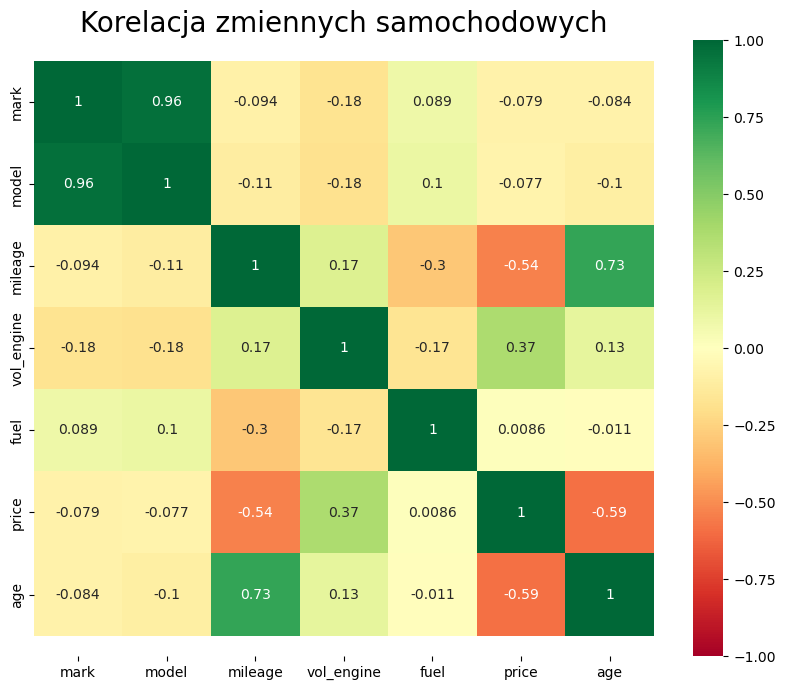

In [26]:
plt.figure(figsize=(10, 8))

# wizualizacja Heatmapy korelacji
ax = sns.heatmap(df.corr(),
                 xticklabels=df.corr().columns,
                 yticklabels=df.corr().columns, 
                 cmap='RdYlGn', 
                 vmin=-1, vmax=1,
                 annot=True, center=0)

# dekoracja wykresu
plt.title('Korelacja zmiennych samochodowych', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25) # odsunięcie etykiet od wykresu

# Zmiana wymiaru etykiet
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Powyższa macierz korelacji pokazuje nam zależności między zmiennymi a ceną samochodu. Można zauważyć, że:

Istnieje silna dodatnia korelacja między marką a modelem samochodu (0.964735). Oznacza to, że samochody są bezpośrednio związane z danym modelem.

Umiarkowanie ujemna korelacja występuje między przebiegiem a ceną (-0.535711). Oznacza to, że wraz ze wzrostem przebiegu, cena samochodów maleje.

Obserwujemy również, niską korelacje zmiennej pojemności silnika, a jego ceną. Wnioskujemy z tego, że nie jest to główny paramter, który decyduje o wartości samochodu, nie mniej jednak mniej pojemne silniki są na ogół tańsze.

Istnieje także umiarkowanie ujemna korelacja między wiekiem a ceną (-0.591388). Starsze samochody mają tendencję do bycia tańszymi. Wiąże się to z ich wytrzymałością oraz generalnym stanem zuzycia. Jest to oczywisty i znaczący parametr w momencie decyzji klienta.

Podsumowując, cena samochodu wykazuje związki korelacyjne z innymi zmiennymi. Przebieg i wiek są istotnymi czynnikami wpływającymi na cenę samochodu, przy czym większy przebieg i starszy wiek często skutkują niższą ceną.

## Zbiór treningowy i testowy

In [27]:
X = df[['mark', 'model','mileage', 'vol_engine', 'age']]
Y = df[['price']]

In [28]:
X.shape

(116667, 5)

In [29]:
Y.shape

(116667, 1)

Dzielimy zbiór na testowy (80%) i treningowy (20%).

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Sprawdzamy poprawność podziału zbioru.

In [31]:
for subset in [X, Y, X_train, Y_train, X_test, Y_test]:
    print(subset.shape)

(116667, 5)
(116667, 1)
(93333, 5)
(93333, 1)
(23334, 5)
(23334, 1)


In [32]:
23334/116667 * 100

20.000514284244904

Z powyższego obliczenia widać, że zbiór testowy ma 20%.

## Model

Następną cześcią jest stworzenie modelu regresji i wypisanie jego współczynników oraz wyrazu wolnego.

In [33]:
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [34]:
model.coef_ # współczynniki modelu

array([[ 1.21394794e+03, -1.43169429e+02, -2.77555604e-01,
         6.28340600e+01, -6.42306010e+03]])

In [35]:
model.intercept_ # wyraz wolny

array([63636.87953613])

Równanie naszego modelu to:

Cena = marka ⋅ 1213.94794 + model ⋅ (-143.169429) + przebieg ⋅ (-0.277555604) + pojemność_silnika ⋅ 62.8340600 + wiek ⋅ (-6423.06010) + 63636.87953613

## Predykcja

In [36]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

In [37]:
R2_train = r2_score(y_true = Y_train, y_pred = y_predict_train)
R2_test = r2_score(y_true = Y_test, y_pred = y_predict_test)

MAE_train = mean_absolute_error(y_true = Y_train, y_pred = y_predict_train)
MAE_test = mean_absolute_error(y_true = Y_test, y_pred = y_predict_test)

MSE_train = mean_squared_error(y_true = Y_train, y_pred = y_predict_train)
MSE_test = mean_squared_error(y_true = Y_test, y_pred = y_predict_test)

RMSE_train = mean_squared_error(y_true = Y_train, y_pred = y_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = Y_test, y_pred = y_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.6037439697869535,     R2_test = 0.6017262709169408,
MAE_train = 30715.05372218658,    MAE_test = 31245.484516787255,
MSE_train = 2727609052.7549496,    MSE_test = 2831072967.4295597,
RMSE_train = 52226.51675877829,    RMSE_test = 53207.828065328504 


Powyższe wyniki uzyskanego modelu nie spełniają oczekiwań utrzymując się na poziomie R^2 = 60%. Regresja Liniowa / wieloraka w tym przypadku nie jest odpowiednim modelem. Jest to ze względu na dużą ilość unikalnych danych jakościowych (marka, model). Jak było widać na macierzy korelacji, nie mają one większego znaczenia w regresji, jednakowoż intuicyjnie wiadomo, że marka i model mają zdecydowany wpływ na cenę.

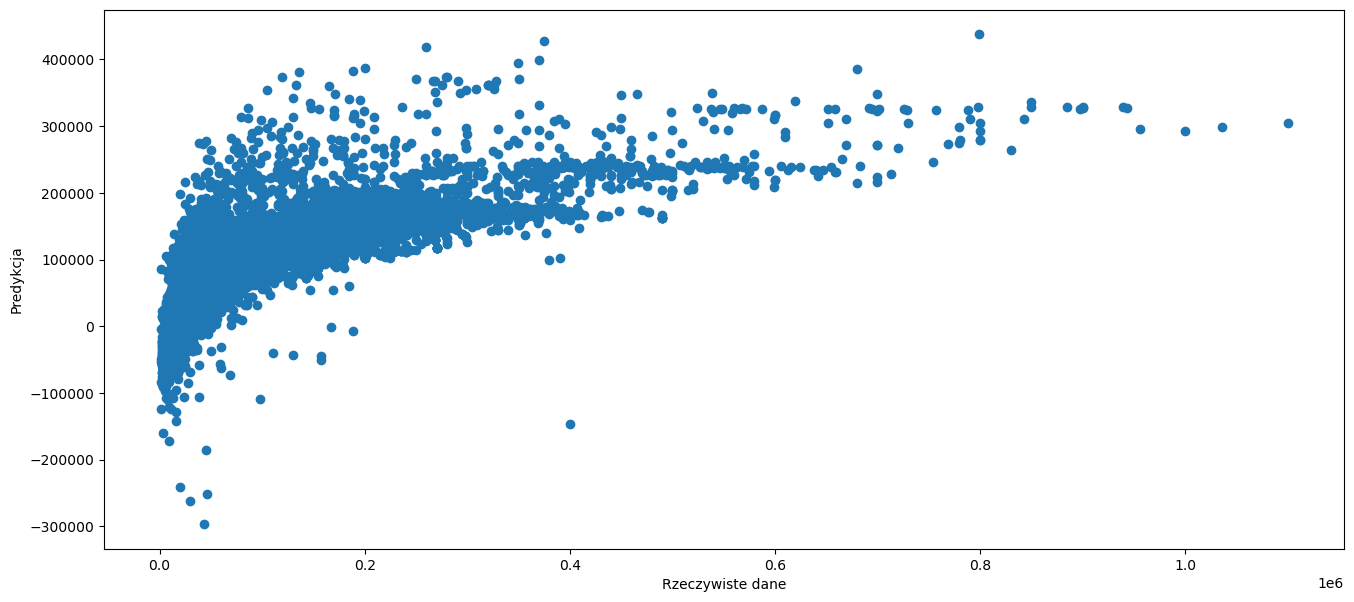

In [38]:
fig, ax = plt.subplots(figsize=(16,7))

ax.scatter(x=Y_test,
           y=y_predict_test)

ax.set_xlabel('Rzeczywiste dane')
ax.set_ylabel('Predykcja')

plt.show()

Wykres pokazuje, że przewidywane wyniki są mocno zaniżone względem rzeczywistych. Dla niższych argumntów przyjmuje nawet ujemne wartości, lecz zasadniczo posiada duży współczynnik losowości. Wykres przyjmuje postać logarytmiczną, co oznacza, że dla wyższych cen rzeczywistych model przewiduje kilkukrotnie niższe wartości.

## Las losowy (Random Forest)

Las losowy to model która polega na konstruowaniu wielu drzew decyzyjnych w czasie uczenia i generowaniu klasy, która jest dominantą klas (klasyfikacja) lub przewidywaną średnią (regresja) poszczególnych drzew.  
Sprawdza się on dobrze w przypadku dużej ilości rozgałęziających się danych tak jak w naszym przypadku (marki oraz modele samochodów lub pojemność silnika).

In [39]:
forest_model=RandomForestRegressor()
forest_model.fit(X_train,Y_train)

/tmp/ipykernel_20/864675363.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_model.fit(X_train,Y_train)


RandomForestRegressor()

In [40]:
y_predict_train = forest_model.predict(X_train)
y_predict_test = forest_model.predict(X_test)

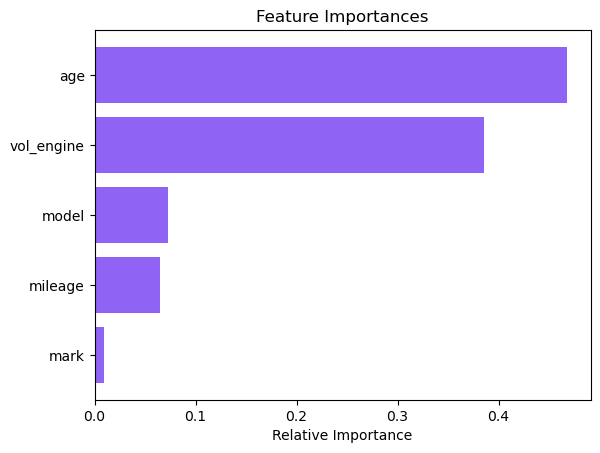

In [41]:
features = ['mark', 'model','mileage', 'vol_engine', 'age']
importances = forest_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Na powyższym wykresie widać, że model jest podobnej wagi co przebieg a marka jest najmniej istotna, co wskazuje na to, że jest zbyt ogólnym parametrem. 

In [42]:
R2_train = r2_score(y_true = Y_train, y_pred = y_predict_train)
R2_test = r2_score(y_true = Y_test, y_pred = y_predict_test)

MAE_train = mean_absolute_error(y_true = Y_train, y_pred = y_predict_train)
MAE_test = mean_absolute_error(y_true = Y_test, y_pred = y_predict_test)

MSE_train = mean_squared_error(y_true = Y_train, y_pred = y_predict_train)
MSE_test = mean_squared_error(y_true = Y_test, y_pred = y_predict_test)

RMSE_train = mean_squared_error(y_true = Y_train, y_pred = y_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = Y_test, y_pred = y_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.9859086497445125,     R2_test = 0.944068151072568,
MAE_train = 3884.898503424351,    MAE_test = 8811.15079962695,
MSE_train = 96997122.04188648,    MSE_test = 397583706.76712036,
RMSE_train = 9848.711694525658,    RMSE_test = 19939.501166456506 


Powyższe wyniki w metryce R^2 zdecydowanie spełniają oczekiwania w zbiorze treningowym na poziomie 98,53% oraz 94,4% w zbiorze testowym. Oznacza to, że model jest w niewielkim stopniu dopasowany do danych, lecz uzyskujemy mimo to wysoki wynik w zbiorze testowym, co jest pożądane. W tym modelu marka i model samochodu są już wykorzystywane w większym stopniu ze względu na użytą strukturę drzewa decyzyjnego. Obie te zmienne są używane w przewidywaniu cen, ponieważ mając niewielką ilość informacji w zbiorze danych o samym samochodzie, marka i model samochodu mogą nieść za sobą również przypisane do nich technologie, design, czy też rodzaje silników. Mimo wszystko, model jest istotniejszy niż marka, ale w niewielkim stopniu.


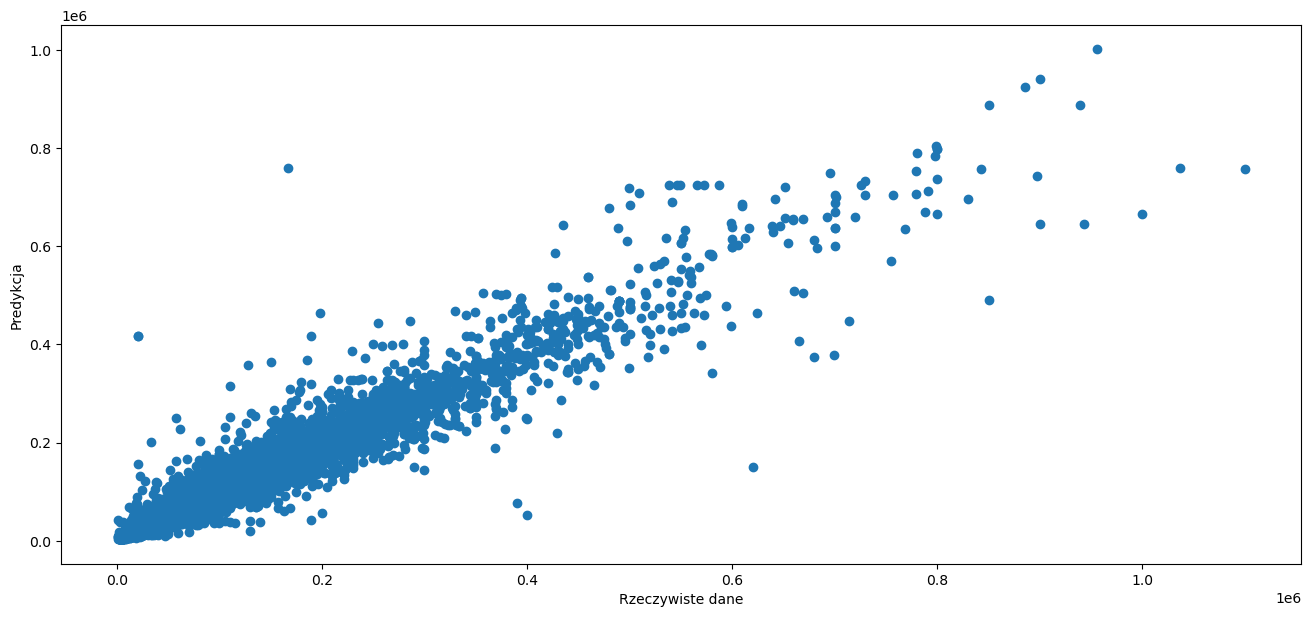

In [43]:
fig, ax = plt.subplots(figsize=(16,7))

ax.scatter(x=Y_test,
           y=y_predict_test)

ax.set_xlabel('Rzeczywiste dane')
ax.set_ylabel('Predykcja')

plt.show()

Powyższy wygląd wykresu jest zdecydowanie pożądany ze względu na swój kształt, zbliżony do y=x, co potwierdza skuteczność modelu. Pomimo wyraźnego rozproszenia wyższych wartości, model utrzymuje efektywność.

# Pozyskanie aktualnych danych

Przy użyciu gotowego [scrapera otomoto](https://github.com/jedrzejd/Otomoto-Scraper) z repozytorium na githubie ograniczyliśmy ilość marek do potrzebnych, oraz ilość informacji do tych na których został wytrenowany model. Przez ponad 3 godziny program zebrał około 32 tysiące wyników. Pozostało jedynie sprawdzić istnienie tych samych modeli, w przeciwnym razie zredukować brakujące dane.

In [44]:
sdf = pd.read_csv('../input/scraped-car-prices-from-otomoto/car.csv')
sdf.head()

,Marka pojazdu,Model pojazdu,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Cena
0,Opel,Corsa,2019,27 000 km,1 398 cm3,Benzyna,44900
1,Opel,Insignia,2016,225 000 km,1 998 cm3,Benzyna,26000
2,Opel,Zafira,2015,263 345 km,1 956 cm3,Diesel,29000
3,Opel,Insignia,2009,186 400 km,1 998 cm3,Benzyna,28900
4,Opel,Astra,2010,130 402 km,1 364 cm3,Benzyna,26899


## Czyszczenie danych

Należy jako pierwsze usunąć jednostki w przebiegu i pojemności skokowej (objętości silnika)

In [45]:
sdf['Przebieg'] = sdf['Przebieg'].str.replace(' km', '')
sdf['Pojemność skokowa'] = sdf['Pojemność skokowa'].str.replace(' cm3', '')

Kolejny krok to zamiana roku na lata

In [46]:
sdf['Wiek'] = 2023 - sdf['Rok produkcji']
sdf.drop(columns=['Rok produkcji'], inplace=True)

Następnie, sprawdzić po kolei unikalne wartości w kolumnach

In [47]:
sdf['Rodzaj paliwa'].unique()

array(['Benzyna', 'Diesel', 'Benzyna+LPG', 'Hybryda', 'Elektryczny',
       'Benzyna+CNG'], dtype=object)

In [48]:
df['fuel'].unique()

array([0, 1, 2, 3, 4])

Benzyna+LPG to w poprzednim DataFramie LPG, a Benzyna+CNG to CNG. Należy przede wszystkim usunąć wszystkie samochody elektryczne, ze względu na poprzednią konwencję.

In [49]:
sdf.drop(sdf.loc[sdf['Rodzaj paliwa']=='Elektryczny'].index, inplace=True)

Tak samo jak poprzednio, trzeba usunąć wszystkie zerowe lub nieistniejące pozycje w pojemności silnika.

In [50]:
sdf.isna().sum()

Marka pojazdu          0
Model pojazdu          0
Przebieg             136
Pojemność skokowa     15
Rodzaj paliwa          0
Cena                   0
Wiek                   0
dtype: int64

In [51]:
sdf.loc[sdf['Pojemność skokowa']==0]

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Rodzaj paliwa,Cena,Wiek


In [52]:
# sdf.drop(sdf.loc[sdf['Pojemność skokowa'].isna()].index, inplace=True)

W przebiegu można uznać, że te wartości są równe 0.

In [53]:
sdf['Przebieg'] = sdf['Przebieg'].fillna(0)

### Statystyki opisowe

In [54]:
sdf.head()

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Rodzaj paliwa,Cena,Wiek
0,Opel,Corsa,27 000,1 398,Benzyna,44900,4
1,Opel,Insignia,225 000,1 998,Benzyna,26000,7
2,Opel,Zafira,263 345,1 956,Diesel,29000,8
3,Opel,Insignia,186 400,1 998,Benzyna,28900,14
4,Opel,Astra,130 402,1 364,Benzyna,26899,13


In [55]:
sdf['Przebieg'] = (sdf['Przebieg'].str.replace(' ', '')).apply(pd.to_numeric)
sdf['Pojemność skokowa'] = (sdf['Pojemność skokowa'].str.replace(' ', '')).apply(pd.to_numeric)
sdf['Cena'] = pd.to_numeric(sdf['Cena'], errors='coerce')

In [56]:
sdf.head()

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Rodzaj paliwa,Cena,Wiek
0,Opel,Corsa,27000.0,1398.0,Benzyna,44900.0,4
1,Opel,Insignia,225000.0,1998.0,Benzyna,26000.0,7
2,Opel,Zafira,263345.0,1956.0,Diesel,29000.0,8
3,Opel,Insignia,186400.0,1998.0,Benzyna,28900.0,14
4,Opel,Astra,130402.0,1364.0,Benzyna,26899.0,13


Zanim do statystyk opisowych, należało powyżej zamienić obecny typ string na numeryczny aby można było wykonywać obliczenia.

In [57]:
sdf.describe().round(2)

,Przebieg,Pojemność skokowa,Cena,Wiek
count,31762.00,31883.00,31889.00,31898.00
mean,137890.73,1834.94,75920.71,9.11
std,94974.74,720.86,87862.00,6.68
min,1.00,499.00,1111.00,0.00
25%,60400.00,1422.00,24500.00,4.00
50%,140000.00,1686.00,47800.00,8.00
75%,201390.50,1995.00,94900.00,13.00
max,2342344.00,7440.00,1399000.00,101.00


Tak jak poprzednio, uwzględnimy markę oraz model samochodu. Model regresji liniowej jest czuły na zmiany kolejności w tym przypadku, dlatego istotne jest zachować kolejność. w przypadku nie istnienia modelu samochodu, zostanie on usunięty.

In [58]:
df_mark_names[9] = 'alfa romeo'
df_mark_names # nazwy dla poprzedniego zbioru

array(['opel', 'audi', 'bmw', 'volkswagen', 'ford', 'mercedes-benz',
       'renault', 'toyota', 'skoda', 'alfa romeo', 'chevrolet', 'citroen',
       'fiat', 'honda', 'hyundai', 'kia', 'mazda', 'mini', 'mitsubishi',
       'nissan', 'peugeot', 'seat', 'volvo'], dtype=object)

In [59]:
def flatten_lower(element):
  return unidecode(element.lower())
sdf['Marka pojazdu'] = sdf['Marka pojazdu'].apply(flatten_lower)

sdf.head()

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Rodzaj paliwa,Cena,Wiek
0,opel,Corsa,27000.0,1398.0,Benzyna,44900.0,4
1,opel,Insignia,225000.0,1998.0,Benzyna,26000.0,7
2,opel,Zafira,263345.0,1956.0,Diesel,29000.0,8
3,opel,Insignia,186400.0,1998.0,Benzyna,28900.0,14
4,opel,Astra,130402.0,1364.0,Benzyna,26899.0,13


In [60]:
sdf['Model pojazdu'] = sdf['Model pojazdu'].apply(flatten_lower)
sdf_model_names = sdf['Model pojazdu'].unique()
print(len(df_model_names), len(sdf_model_names))

321 630


In [61]:
diff = list(set(sdf_model_names) - set(df_model_names))
print(len(sdf_model_names) - len(diff))
list(set(sdf_model_names) - set(diff))
diff

235


['supra',
 'blazer',
 '107',
 '19',
 'ulysse',
 'sq8',
 'genesis',
 'arosa',
 'rs7',
 'amg gt',
 'paseo',
 's 2000',
 'prius+',
 'focus c-max',
 'jumper',
 'grandland',
 'previa',
 'tacoma',
 'klasa b',
 'rx-8',
 'grand scenic',
 'cla',
 'suburban',
 'gle',
 'sonata',
 'traverse',
 'terracan',
 'nubira',
 'proace city verso',
 'sunny',
 'c4x',
 'slk',
 'klasa s',
 'taigo',
 'c1',
 'prelude',
 '2500',
 'maxima',
 'fr-v',
 'captiva',
 'frontier',
 'yaris cross',
 '323',
 '307 cc',
 'i30 n',
 '301',
 'trajet',
 'genesis coupe',
 '2 cv',
 'm6',
 'brera',
 'passat cc',
 'ml',
 'integra',
 'grand c-max',
 'rio',
 'qashqai+2',
 'legend',
 'qubo',
 'seicento',
 'nemo',
 'cinquecento',
 'land cruiser',
 'cls',
 'terrano',
 'laurel',
 'c3 picasso',
 '127',
 'clk',
 'camry solara',
 'klasa g',
 'demio',
 'primastar',
 'xsara',
 '300 zx',
 '1500',
 'xsara picasso',
 '125p',
 'tourneo connect',
 'bora',
 'bipper',
 'kadett',
 'hhr',
 'atlas',
 'x 1',
 'xc 70',
 'gr86',
 'shuma',
 'hilux',
 'sedona'

Powyżej znajduje się lista 235 modeli samochodów które są wspólne dla obu zbiorów danych.

In [62]:
sdf.drop(sdf.loc[sdf['Model pojazdu'].isin(diff)].index, inplace=True)
len(sdf['Model pojazdu'].unique())

235

Należało usunąć wszystkie modele które nie znajdywały się w pierwszym zbiorze, a były w nowym, pozyskanym. W tabeli diff znajdywały się takie pozycje.

In [63]:
unique_vals = df_mark_names
sdf['Marka pojazdu'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)
sdf['Marka pojazdu'].unique()
unique_vals = df_model_names
# unique_vals = sdf['model'].unique()
sdf['Model pojazdu'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))),
           inplace=True)
# unique_vals = sdf['fuel'].unique()
# sdf['fuel'].replace(to_replace=unique_vals,
#            value= list(range(len(unique_vals))),
#            inplace=True)

In [64]:
sdf['Model pojazdu'].unique()

array([  7,  11,  13,   6,  19,  17,   1,  12,  16,   0,   4,   5,  20,
         2,   3,  18,  33,  27,  14,  32,  41,  34,  26,  24,  31,  29,
        30,  22,  35,  36,  44,  40,  21,  37,  43,  23,  42,  38,  61,
        67,  63,  65,  64,  45,  51,  62,  49,  52,  46,  69,  50,  48,
        87,  97,  95,  94,  80,  70,  71,  76,  73,  98,  83,  91,  92,
        78,  72,  85,  90,  75,  93,  74,  99,  77,  79,  89,  84, 109,
       117, 107, 104, 116, 108, 119, 118, 115, 120, 103, 112, 106, 105,
       111, 101, 102, 124, 114, 152, 151, 153, 149, 128, 165, 156, 162,
       155, 157, 167, 168, 161, 163, 170, 164, 154, 160, 171, 166, 169,
       191, 186, 187, 195, 190, 189, 192, 188, 194, 196, 193, 173, 172,
       182, 177, 184, 175, 180, 176, 174, 185, 183, 291, 295, 296, 294,
       298, 289, 293, 288, 290, 292, 297, 287, 308, 314, 310, 316, 313,
       312, 315, 309, 311, 238, 240, 239, 243, 236, 234, 237, 241, 235,
       252, 245, 247, 249, 246, 251, 253, 250, 255, 254, 244, 27

In [65]:
sdf[sdf.isna().any(axis=1)].count()

Marka pojazdu        103
Model pojazdu        103
Przebieg               5
Pojemność skokowa     97
Rodzaj paliwa        103
Cena                 102
Wiek                 103
dtype: int64

Okazuje się, że być może po wszystkich zmianach pozostały jakieś wartości nieistniejące w danych.

In [66]:
sdf.dropna(inplace=True)
sdf.describe().round(2)

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Cena,Wiek
count,24010.00,24010.00,24010.00,24010.00,24010.00,24010.00
mean,10.55,190.14,139758.46,1745.94,65257.46,8.89
std,6.73,89.50,91221.02,574.50,68141.66,5.81
min,0.00,0.00,1.00,499.00,1111.00,0.00
25%,4.00,117.00,66000.00,1396.00,24500.00,4.00
50%,10.00,204.00,143000.00,1598.00,44900.00,8.00
75%,16.00,257.00,202000.00,1991.00,83500.00,13.00
max,22.00,316.00,1000000.00,6600.00,1198899.00,73.00


## Korelacja aktualnych danych

/tmp/ipykernel_20/373009149.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(sdf.corr(),
/tmp/ipykernel_20/373009149.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  xticklabels=sdf.corr().columns,
/tmp/ipykernel_20/373009149.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  yticklabels=sdf.corr().columns,


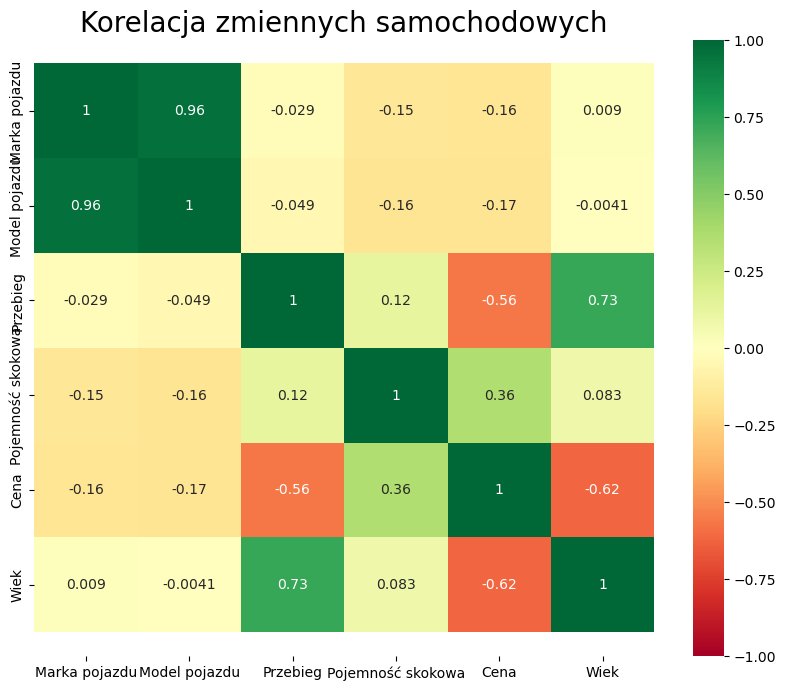

In [67]:
plt.figure(figsize=(10, 8))

# wizualizacja Heatmapy korelacji
ax = sns.heatmap(sdf.corr(),
                 xticklabels=sdf.corr().columns,
                 yticklabels=sdf.corr().columns, 
                 cmap='RdYlGn', 
                 vmin=-1, vmax=1,
                 annot=True, center=0)

# dekoracja wykresu
plt.title('Korelacja zmiennych samochodowych', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25) # odsunięcie etykiet od wykresu

# Zmiana wymiaru etykiet
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## Predykcja nowych danych

Nowe dane są traktowane w całości jako zbiór testowy

In [68]:
sX_test = sdf[['Marka pojazdu', 'Model pojazdu','Przebieg', 'Pojemność skokowa', 'Wiek']]
sY_test = sdf[['Cena']]
sX_test.rename(columns = {'Marka pojazdu':'mark', 'Model pojazdu':'model', 'Przebieg':'mileage', 'Pojemność skokowa':'vol_engine', 'Wiek':'age'}, inplace=True)
sY_test.rename(columns = {'Cena':'price'}, inplace=True)
sX_test

/tmp/ipykernel_20/3128767355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sX_test.rename(columns = {'Marka pojazdu':'mark', 'Model pojazdu':'model', 'Przebieg':'mileage', 'Pojemność skokowa':'vol_engine', 'Wiek':'age'}, inplace=True)
/tmp/ipykernel_20/3128767355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sY_test.rename(columns = {'Cena':'price'}, inplace=True)


,mark,model,mileage,vol_engine,age
0,0,7,27000.0,1398.0,4
1,0,11,225000.0,1998.0,7
2,0,13,263345.0,1956.0,8
3,0,11,186400.0,1998.0,14
4,0,6,130402.0,1364.0,13
...,...,...,...,...,...
32416,10,202,147000.0,1399.0,15
32419,10,202,70000.0,1206.0,15
32422,10,205,216000.0,1796.0,12
32423,10,205,132000.0,1796.0,11


In [69]:
sX_test.shape

(24010, 5)

In [70]:
sY_test.shape

(24010, 1)

Następnie, cały poprzedni zbiór traktujemy jako zbiór treningowy

In [71]:
sX_train = df[['mark', 'model','mileage', 'vol_engine', 'age']]
sY_train = df[['price']]

In [72]:
sX_train.shape

(116667, 5)

In [73]:
sY_train.shape

(116667, 1)

Następnie używamy lepszego modelu (las losowy) nie wydzielając zbioru treningowego do predykcji nowych wyników

In [74]:
sforest_model=RandomForestRegressor()
sforest_model.fit(sX_train,sY_train)

/tmp/ipykernel_20/3301179648.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  sforest_model.fit(sX_train,sY_train)


RandomForestRegressor()

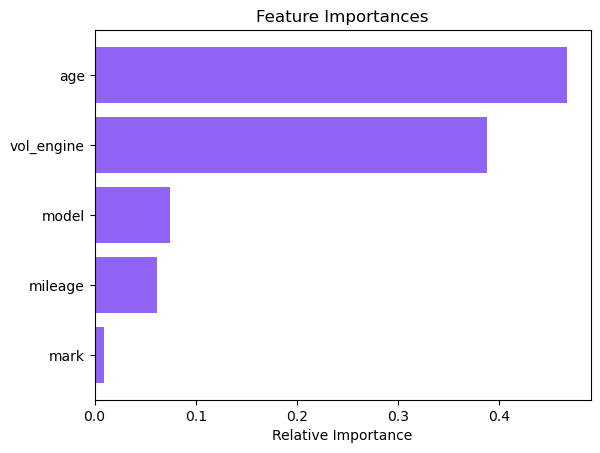

In [75]:
features = ['mark', 'model','mileage', 'vol_engine', 'age']
importances = sforest_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [76]:
sy_predict_train = sforest_model.predict(sX_train)
sy_predict_test = sforest_model.predict(sX_test)

In [77]:
R2_train = r2_score(y_true = sY_train, y_pred = sy_predict_train)
R2_test = r2_score(y_true = sY_test, y_pred = sy_predict_test)

MAE_train = mean_absolute_error(y_true = sY_train, y_pred = sy_predict_train)
MAE_test = mean_absolute_error(y_true = sY_test, y_pred = sy_predict_test)

MSE_train = mean_squared_error(y_true = sY_train, y_pred = sy_predict_train)
MSE_test = mean_squared_error(y_true = sY_test, y_pred = sy_predict_test)

RMSE_train = mean_squared_error(y_true = sY_train, y_pred = sy_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = sY_test, y_pred = sy_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.9856137610387262,     R2_test = 0.8828543409023101,
MAE_train = 3844.6280860854436,    MAE_test = 11657.95443571461,
MSE_train = 99674185.23312038,    MSE_test = 543918093.6388292,
RMSE_train = 9983.695970587265,    RMSE_test = 23322.051660152654 


Jak widać, cały użyty zbiór treningowy ma dokładność subtelnie lepszą (wcześniej 98,508%, teraz 98,55%). Użyty jednak zbiór danych testowych ma zdecydowanie niższy wynik niż poprzednio (94,335%, podczas gdy teraz: 88,4%).

In [78]:
print(sY_test.shape, Y_test.shape)

(24010, 1) (23334, 1)


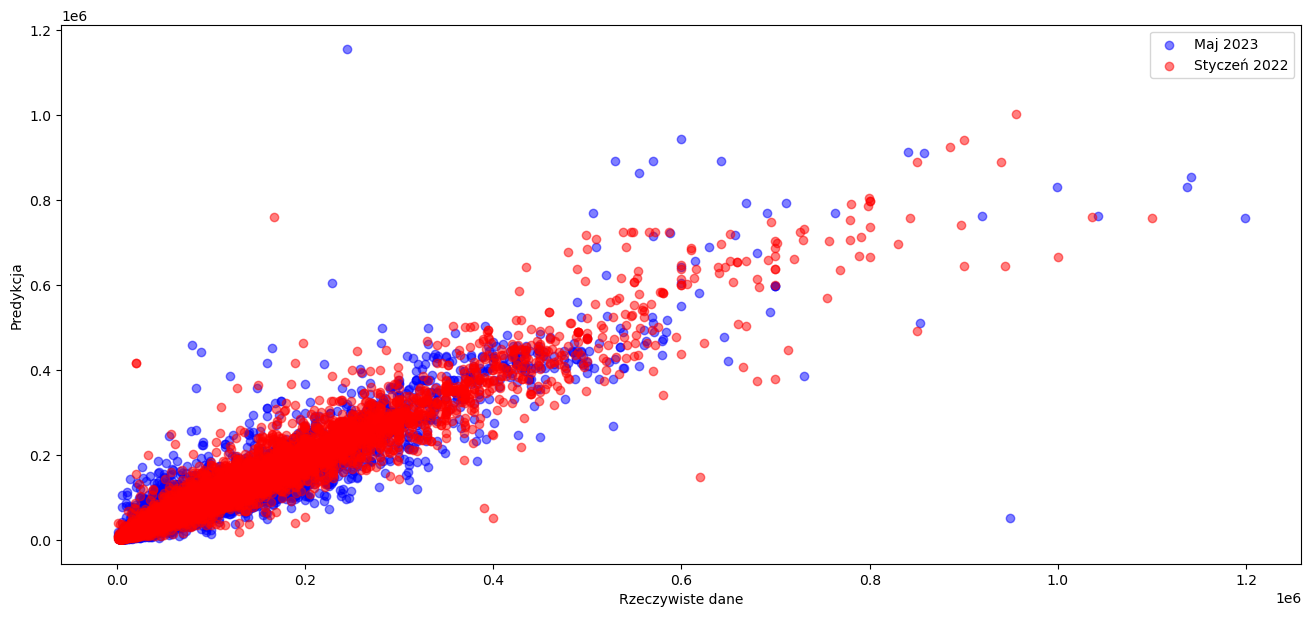

In [79]:
fig, ax = plt.subplots(figsize=(16,7))

ax.scatter(x=sY_test,
           y=sy_predict_test, color='blue', label="Maj 2023", alpha=0.5)
ax.scatter(x=Y_test,
           y=y_predict_test, color='red', label="Styczeń 2022", alpha=0.5)
ax.legend()

ax.set_xlabel('Rzeczywiste dane')
ax.set_ylabel('Predykcja')

plt.show()

Niebieskie punkty oznaczają predykowane punkty z obecnych danych utworzonym modelem lasu losowego. Czerwone natomiast to punkty dla porównania, danych ze stycznia 2022 roku.  
Widać wyraźnie, że nowe punkty są zawuażalnie bardziej rozproszone, a im ceny rzeczywiste powinny być większe, tym wyniki stają się co raz bardziej nieprzewidywalne.

In [80]:
sdf.describe().round(2)

,Marka pojazdu,Model pojazdu,Przebieg,Pojemność skokowa,Cena,Wiek
count,24010.00,24010.00,24010.00,24010.00,24010.00,24010.00
mean,10.55,190.14,139758.46,1745.94,65257.46,8.89
std,6.73,89.50,91221.02,574.50,68141.66,5.81
min,0.00,0.00,1.00,499.00,1111.00,0.00
25%,4.00,117.00,66000.00,1396.00,24500.00,4.00
50%,10.00,204.00,143000.00,1598.00,44900.00,8.00
75%,16.00,257.00,202000.00,1991.00,83500.00,13.00
max,22.00,316.00,1000000.00,6600.00,1198899.00,73.00


# Podsumowanie i wnioski

Pierwsza część tej analizy polegała głównie na badaniu zbioru samochodów ze stycznia 2022 roku, czyszczeniu danych oraz ostatecznie utworzeniu modeli. 
Samochody elektryczne jak się okazało po dokładniejszej inspekcji, nie posiadały dobrze przygotowanych danych, dlatego w tym badaniu zostały one wykluczone.

Model regresji wielorakiej okazał się niewydajny uzyskując wynik na poziomie około R^2=60%, natomiast drugi, drzew losowych, zdecydowanie lepiej się spełnił w tym zadaniu z wynikiem około R^2=94% w zbiorze testowym.  
  
Model regresji wielorakiej nie jest dobrym narzędziem dla tego zbioru danych ze względu na znaczącą ilość skategoryzowanych danych, których reprezentacja liczbowa w modelu regresyjnym jest kwestionowalnym wyborem.  
Las losowy jest znacznie efektywniejszy, ponieważ wykorzystuje drzewa decyzyjne, które dla tego typu danych osiągają lepsze wyniki.
  
W samych modelach, największą rolę odgrywały przede wszystkim dwie zmienne: wiek oraz pojemność skokowa silnika. Intuicyjnie, marka oraz model mają duże znaczenie, jednakowoż dane z korelacji lub wagi cech pokazują, że jest ono niewiększe niż przebieg danego auta.

Druga część sprowadzała się do pozyskania aktualnych danych o samochodach. Aby to osiągnąć, należało użyć tzw. scrapera, czyli narzędzia pozwalającego na pobranie danych z publicznego kodu strony internetowej. Uzyskaliśmy to dzięki [scrapera otomoto](https://github.com/jedrzejd/Otomoto-Scraper) z repozytorium na githubie. Przed uruchomieniem dostosowaliśmy parametry tak, by program pobierał wyłącznie pożądane przez nas marki samochodów, z maksymalnie 50 podstron marki z otomoto.pl. Strona internetowa otomoto to jest arbitralny wybór, ponieważ te dane traktowane są jako próbka polskich cen samochodów w internecie, ze względu na to, że nazwa w zbiorze danych z poprzedniego roku nie jest jawnie opisana.

Pozyskane dane należało również dostosować do modeli samochodów znajdujących się w pierwotnym zbiorze danych, ponieważ model predykujący nie uzyskał tego typu danych.

Ostatecznie, utworzyliśmy model lasu losowego, którego zbiór treningowy to był cały zeszłoroczny zbiór danych, a następnie przewidzieliśmy wyniki dla nowych, aktualnych, samochodów.

## Wnioski

Na podstawie niniejszych badań, można określić, że regresja wieloraka to nieodpowiedni model przewidywania cen samochodów. Lepsze wyniki uzyskuje las losowy, przewidując ceny bieżące, jak w pierwszej części analizy.

W drugiej części, w porównaniu z aktualnym zestawieniem samochodów, model uzyskuje wynik 88,4%, gdzie ceny bieżące potrafi przewidywać z dokładnością nawet 94,3%, jeżeli zbiór treningowy jest wystarczająco duży.

To badanie potwierdza hipotezę H<sub>0</sub> : Za pomocą historycznych danych można przewidzieć ceny bieżących samochodów.


Zważając na wielkość zmiany dokładności modelu, to spadek około 6 pkt. procentowych, co oznacza, że model utrzymuje wysokie prawdopodobieństwo przewidywania. Różnica w dokładności jest widoczna na wykresie porównującym obie predykcje, lecz może ona wynikać z innych zmiennych, takich jak inflacja, lub inne zjawiska ekonomiczne i potrzebna jest weryfikacja tej hipotezy.